# Installation & Setup

Before we proceed, please install the following packages:

In [1]:
] add GeoStats StratiGraphics SpectralGaussianSimulation Plots

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


Pkg.Types.PkgError: Cannot add package with the same name or uuid as the project

In [2]:
using Random; Random.seed!(2019); # make sure this tutorial is reproducible

# Creating surfaces

First, we demonstrate how  Markov-Poisson sampling can be used to generate random surfaces of a 3D stratigraphic model.

We start by defining a set of 2D geostatistical processes:

In [3]:
using GeoStats
using StratiGraphics
using SpectralGaussianSimulation

solver₁ = SpecGaussSim(:land => (variogram=GaussianVariogram(range=100.,sill=3e-2),))
solver₂ = SpecGaussSim(:land => (variogram=GaussianVariogram(range=100.,sill=3e-2),))

procs = [GeoStatsProcess(solver) for solver in [solver₁,solver₂]];

In this example, we define two Gaussian processes. This processes represent smooth "depositional" processes as indicated by the `GaussianVariogram` model. The `range` and `sill` parameters determine the "frequency" and "height" of oscillation in the horizons, respectively.

Having a set of processes defined to evolve a landscape, we need transition probabilities between these processes in order to build stratigraphy over time. Here we say that the two processes are balanced (i.e. 50% / 50% chance in the long run):

In [4]:
P = [0.5 0.5
     0.5 0.5]

2×2 Array{Float64,2}:
 0.5  0.5
 0.5  0.5

Finally, we specify a duration process that determines the (random) amount of time that each process takes before a new transition:

In [5]:
ΔT = ExponentialDuration(1.0)

ExponentialDuration(1.0)

We create a geological environment with the components defined above:

In [6]:
env = Environment(procs, P, ΔT)

Environment(GeoStatsProcess{SpecGaussSim}[GeoStatsProcess{SpecGaussSim}(SpecGaussSim), GeoStatsProcess{SpecGaussSim}(SpecGaussSim)], [0.5 0.5; 0.5 0.5], ExponentialDuration(1.0))

Given an initial state (i.e. flat land), and a number of epochs, we can simulate the environment to produce a geological record:

In [7]:
nepochs = 10 # number of surfaces to simulate

init = LandState(zeros(500,500)) # each surface is a 500x500 image

record = simulate(env, init, nepochs);

From the record, we can extract the surfaces that make the stratigraphic model. Two options are available for stacking the surfaces, they are `:erosional` (default) in which case the surfaces are eroded backward in time, and `:depositional` in which case the surfaces are deposited forward in time:

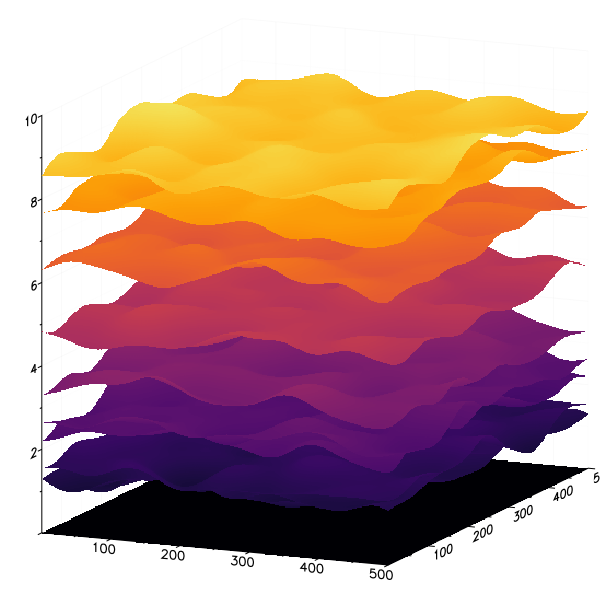

┌ Warning: Overwriting colorbar entry
└ @ Plots /home/juliohm/.julia/packages/Plots/4OMIA/src/backends/gr.jl:438
┌ Warning: Overwriting colorbar entry
└ @ Plots /home/juliohm/.julia/packages/Plots/4OMIA/src/backends/gr.jl:438
┌ Warning: Overwriting colorbar entry
└ @ Plots /home/juliohm/.julia/packages/Plots/4OMIA/src/backends/gr.jl:438
┌ Warning: Overwriting colorbar entry
└ @ Plots /home/juliohm/.julia/packages/Plots/4OMIA/src/backends/gr.jl:438
┌ Warning: Overwriting colorbar entry
└ @ Plots /home/juliohm/.julia/packages/Plots/4OMIA/src/backends/gr.jl:438
┌ Warning: Overwriting colorbar entry
└ @ Plots /home/juliohm/.julia/packages/Plots/4OMIA/src/backends/gr.jl:438
┌ Warning: Overwriting colorbar entry
└ @ Plots /home/juliohm/.julia/packages/Plots/4OMIA/src/backends/gr.jl:438
┌ Warning: Overwriting colorbar entry
└ @ Plots /home/juliohm/.julia/packages/Plots/4OMIA/src/backends/gr.jl:438
┌ Warning: Overwriting colorbar entry
└ @ Plots /home/juliohm/.julia/packages/Plots/4OMIA/src/ba

In [8]:
using Plots; gr(format=:png)

strata = Strata(record)

plot(strata, size=(600,600))

We can convert the stratigraphic model into a 3D voxel model by specifying a vertical resolution:

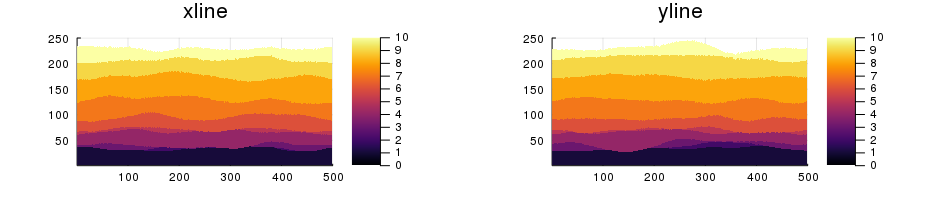

In [9]:
model = voxelize(strata, 250) # 500x500x250 voxel model

xslice = rotr90(model[25,:,:])
yslice = rotr90(model[:,25,:])

px = heatmap(xslice, title="xline")
py = heatmap(yslice, title="yline")

plot(px, py, size=(950,200), aspect_ratio=:equal, clim=(0,nepochs))

# Putting it all together

We can create many such stratigraphic models by defining a simulation problem for stratigraphy:

In [10]:
problem = SimulationProblem(RegularGrid{Float64}(500,500,250), :strata => Float64, 3)

3D SimulationProblem (unconditional)
  domain:    500×500×250 RegularGrid{Float64,3}
  variables: strata (Float64)
  N° reals:  3

The `StratSim` solver is compliant with the GeoStats.jl API:

In [11]:
solver = StratSim(:strata => (environment=env,))

StratSim
  └─strata
    └─environment ⇨ Environment(GeoStatsProcess{SpecGaussSim}[GeoStatsProcess{SpecGaussSim}(SpecGaussSim), GeoStatsProcess{SpecGaussSim}(SpecGaussSim)], [0.5 0.5; 0.5 0.5], ExponentialDuration(1.0))
    └─stack ⇨ :erosional
    └─nepochs ⇨ 10
    └─fillbase ⇨ NaN
    └─filltop ⇨ NaN


In [12]:
Random.seed!(2000)

solution = solve(problem, solver)

3D SimulationSolution
  domain: 500×500×250 RegularGrid{Float64,3}
  variables: strata

The solution contains 3 realizations of stratrigraphy, which can be visualized with:

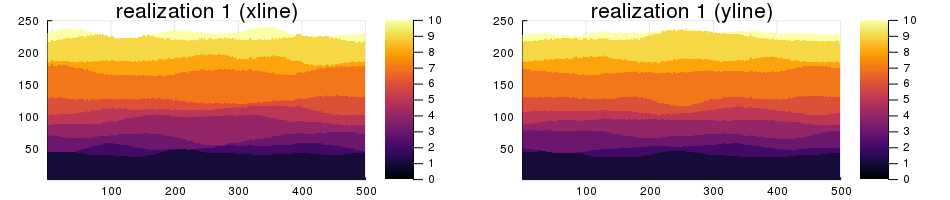

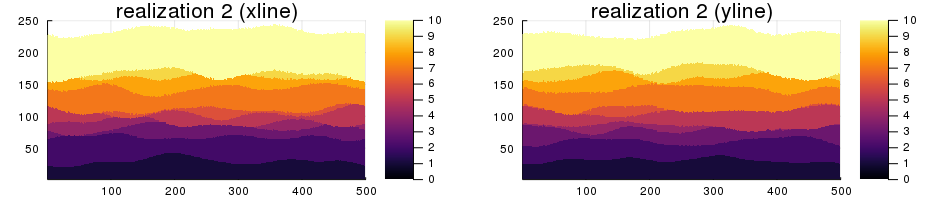

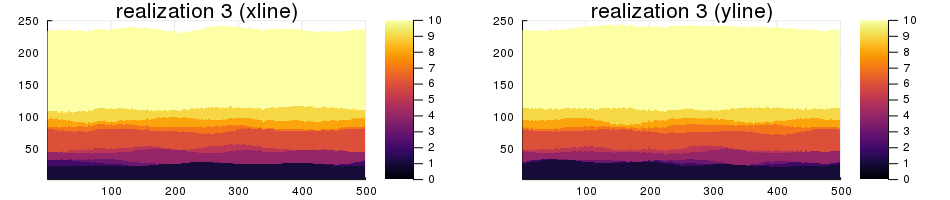

In [13]:
for (i,real) in enumerate(solution[:strata])
    xslice = rotr90(real[25,:,:])
    yslice = rotr90(real[:,25,:])
    
    px = heatmap(xslice, title="realization $i (xline)", clim=(0,nepochs))
    py = heatmap(yslice, title="realization $i (yline)", clim=(0,nepochs))
    
    p = plot(px, py, aspect_ratio=:equal, size=(950,200))
    
    display(p)
end